In [190]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F

In [354]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=(7, 12), stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=2, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

#         self.conv3 = nn.Conv2d(16, 64, kernel_size=4, stride=2, padding=1)
#         self.bn3 = nn.BatchNorm2d(64)

#         self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1)
#         self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=2, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=(8, 12), stride=1, padding=2) 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        
#         e1 = self.bn1(self.conv1(input))
#         e2 = self.bn2(self.conv2(e1))
#         e3 = self.bn3(self.conv3(e2))
        
#         e4 = self.bn4(self.conv4(e3))
#         e5 = self.bn5(self.conv5(e4))
#         e6 = self.conv6(e5)

#         return e6
        e1 = self.conv1(input)
#         print(e1.shape)
        bn1 = self.bn1(self.act(e1))
#         print(bn1.shape)
        e2 = self.bn2(self.conv2(bn1))
#         print(e2.shape)
        m3, indices =self.maxpool(e2)
#         print(m3.shape)
        um = self.unpool(m3, indices)
#         print(um.shape)
#         e5 = self.bn5(self.conv5(e2))
        e5 = self.bn5(self.conv5(um))
#         print(e5.shape)
        e6 = self.conv6(e5)
#         print(e6.shape)

        return e6



In [355]:
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

model = Net()
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.5)

num_folds = 5
fold_num = 0
train, test = get_train_test(3, num_folds=num_folds, fold_num=fold_num)

valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
print(train_aggregate.shape)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

(43, 1, 112, 24)


In [356]:
train[:, 4, :, :].reshape(train.shape[0], 1, train.shape[2], -1).shape

(43, 1, 112, 24)

In [357]:
def reg_loss(pred, out):
    l1_loss = torch.sum(torch.abs(pred-out))  
    reg = 0.5*torch.sum(torch.abs(out))
    return l1_loss + reg

In [358]:
model = Net()

# loss_fn = nn.L1Loss()
loss_fun = reg_loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.5)

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True
if cuda_av:
    model = model.cuda()
    loss_fn = loss_fn.cuda()
app_idx = APPLIANCE_ORDER.index('dr')   
    
inp = Variable(torch.Tensor(train_aggregate))
out = Variable(torch.Tensor(train[:, app_idx, :, :].reshape(train.shape[0], 1, train.shape[2], -1)))
test_inp = Variable(torch.Tensor(test_aggregate))
test_out = Variable(torch.Tensor(test[:, app_idx, :, :].reshape(test.shape[0], 1, test.shape[2], -1)))
if cuda_av:
    inp = inp.cuda()
    out = out.cuda()
    test_inp = test_inp.cuda()
    test_out = test_out.cuda()

In [359]:

for epoch in range(20000):
    
    pred = model(inp)
#     print(pred.shape)
#     pred = torch.clamp(pred, min=0.)
    loss = loss_fn(pred, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch %100 == 0:
        
        
        test_pr = model(test_inp)
        test_pr = torch.clamp(test_pr, min=0.)
        test_loss = loss_fn(test_pr, test_out)
        
        print(epoch, "Training Error:", loss.data[0], "Test Error:", test_loss.data[0])

0 Training Error: 73.16705322265625 Test Error: 51.29369354248047
100 Training Error: 73.03455352783203 Test Error: 51.272708892822266
200 Training Error: 73.03325653076172 Test Error: 51.27429962158203
300 Training Error: 73.03120422363281 Test Error: 51.26973342895508
400 Training Error: 73.02964782714844 Test Error: 51.2689094543457
500 Training Error: 73.02564239501953 Test Error: 51.270591735839844
600 Training Error: 73.01492309570312 Test Error: 51.26634216308594
700 Training Error: 73.00337982177734 Test Error: 51.26567459106445
800 Training Error: 72.98904418945312 Test Error: 51.273006439208984
900 Training Error: 72.9669418334961 Test Error: 51.29762268066406
1000 Training Error: 72.92406463623047 Test Error: 51.272422790527344
1100 Training Error: 73.03971099853516 Test Error: 51.276222229003906
1200 Training Error: 72.97514343261719 Test Error: 51.28558349609375
1300 Training Error: 72.94708251953125 Test Error: 51.347084045410156
1400 Training Error: 72.73229217529297 Tes

11900 Training Error: 67.9146728515625 Test Error: 53.18156814575195
12000 Training Error: 68.73284912109375 Test Error: 52.51873779296875
12100 Training Error: 68.0171890258789 Test Error: 53.00613021850586
12200 Training Error: 67.36298370361328 Test Error: 53.17884826660156
12300 Training Error: 66.55657958984375 Test Error: 52.4526252746582
12400 Training Error: 69.02513885498047 Test Error: 54.26879119873047
12500 Training Error: 67.02149963378906 Test Error: 52.79929733276367
12600 Training Error: 67.13309478759766 Test Error: 55.79112243652344
12700 Training Error: 67.3419189453125 Test Error: 55.25505447387695
12800 Training Error: 67.18470764160156 Test Error: 52.60807418823242
12900 Training Error: 68.33657836914062 Test Error: 52.905975341796875
13000 Training Error: 67.1312026977539 Test Error: 55.15911865234375
13100 Training Error: 66.64854431152344 Test Error: 54.01827621459961
13200 Training Error: 65.96625518798828 Test Error: 52.440643310546875
13300 Training Error: 6

In [360]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [361]:
test_pr = torch.clamp(test_pr, min=0.)
pred = torch.clamp(pred, min=0.)

14


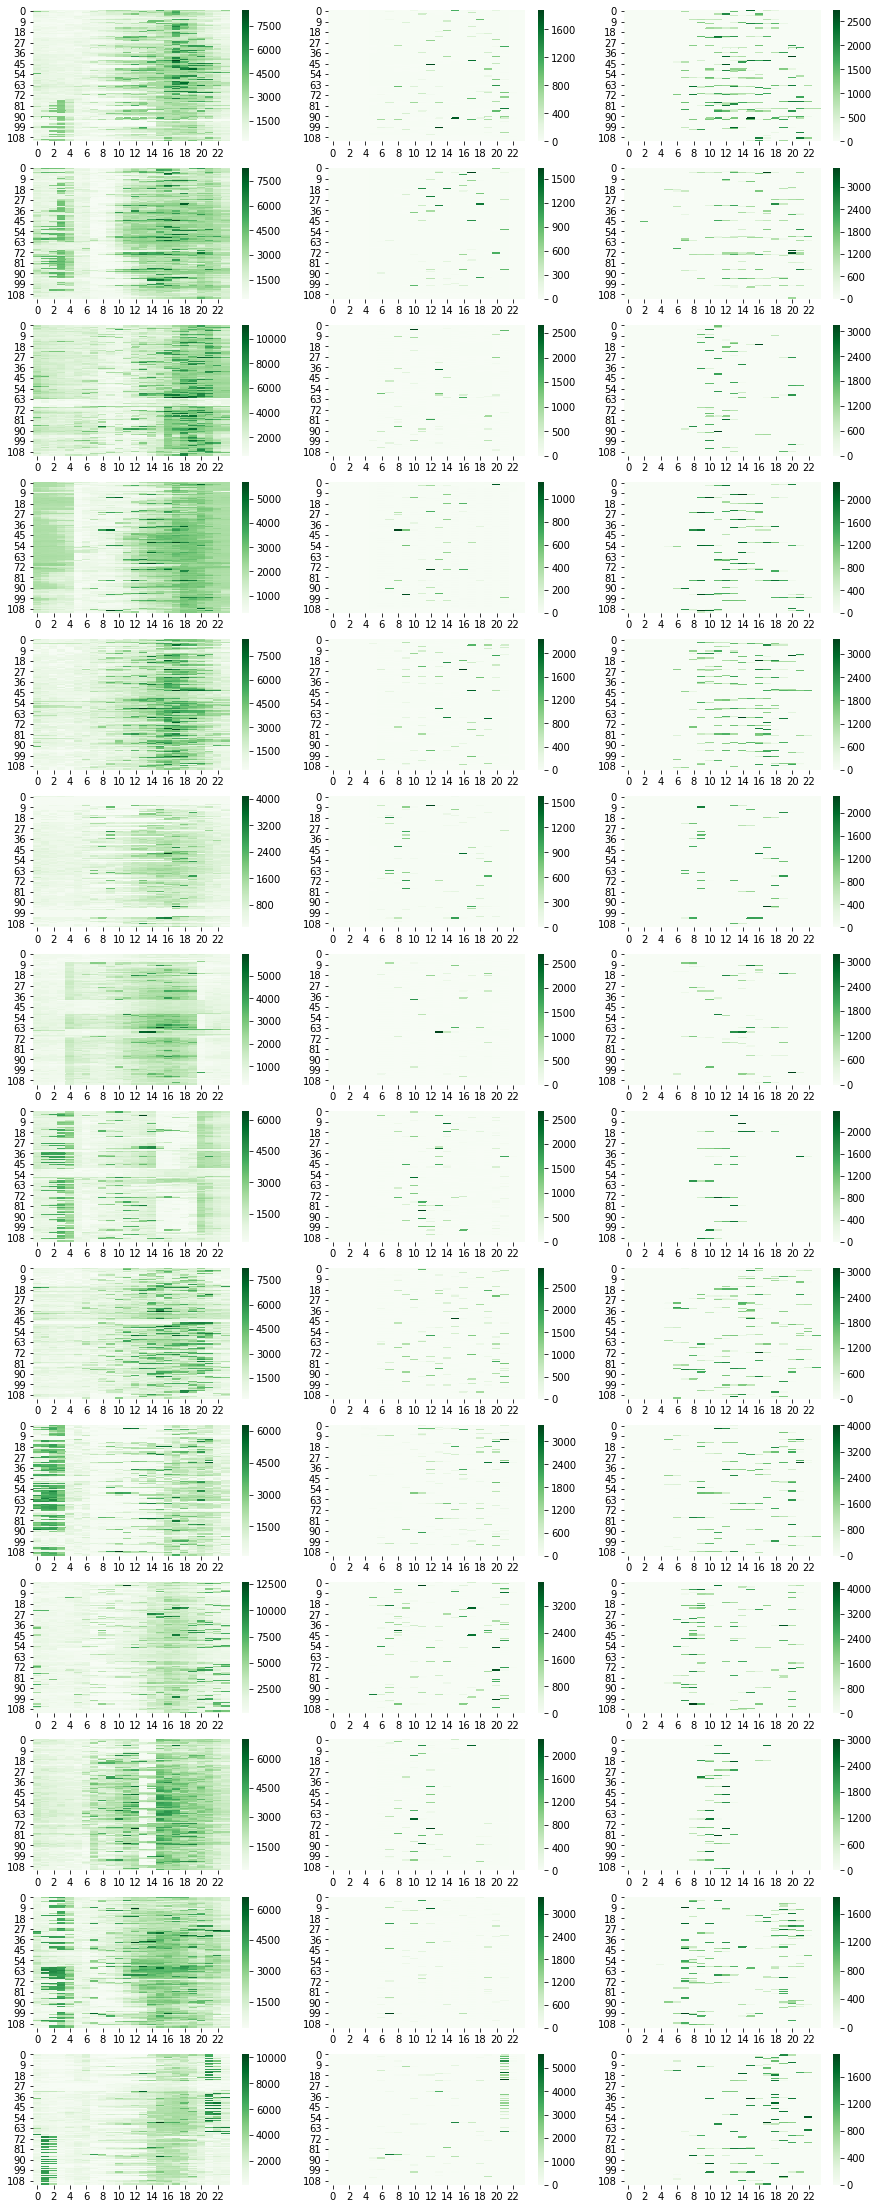

In [362]:
num_test = test_pr.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=num_test,ncols=3, figsize=(15, 40))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)


for i in range(num_test):
    sns.heatmap(pd.DataFrame(test_inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0])
    sns.heatmap(pd.DataFrame(test_pr.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




In [ ]:
num_train = pred.cpu().data.numpy().shape[0]
num_test = pred.cpu().data.numpy().shape[0]
print(num_test)
fig, axes = plt.subplots(nrows=9,ncols=3, figsize=(15, 20))
# ax = axes.flatten()

# pred = test_pr.cpu().data.numpy()
# print(pred.shape)
# print(pred[0][0].shape)



for i in range(num_train):
    sns.heatmap(pd.DataFrame(inp.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 0], vmin=0, vmax=10000)
    sns.heatmap(pd.DataFrame(pred.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 1])
    sns.heatmap(pd.DataFrame(out.cpu().data.numpy()[i][0]), cmap='Greens', ax=axes[i, 2])




43


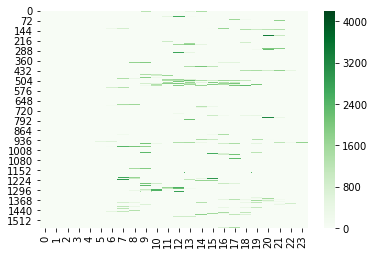

In [388]:
sns.heatmap(pd.DataFrame(test_out.cpu().data.numpy().reshape(-1, 24)), cmap='Greens')